In [114]:
#Gerekli Kütüphanelerin Yüklenmesi

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
import itertools
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding
color = sns.color_palette()
%matplotlib inline
import os
import sys
print(os.listdir("../dataSurgeryThyroid/tyroidXray"))  #Çalışılan kodun dizinindeki resim dosyalarını bulduk



['.ipynb_checkpoints', 'test', 'thyroid.ipynb', 'train', 'tyroidXray.rar', 'val', 'VGG-16']


In [2]:
# Programda karma tabanlı işlemlerin ayarlanması
os.environ['Thyroid'] = '0'

# numpy ayarı
np.random.seed(111)

# çoklu parçacıkları devre dışı bırakma
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Random çekirdeği grafik düzeyinde ayarlama
tf.random.set_seed(111)

# Yapılan ayarlamaların yardımıyla gerekli olan session hazırlanması
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Keras sessionunun ayarlanması
tf.compat.v1.keras.backend.set_session(sess)

# Büyüme sırasını determinant düzleminde sıralanması
aug.seed(111)

In [3]:
# eğitimlerin, testlerin ve değerlerin çalışacağı dosya konumu

data_dir = Path("../dataSurgeryThyroid/tyroidXray")
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [8]:

normal_cases_dir = train_dir / 'normal'
patient_cases_dir = train_dir / 'patient'

# Görüntüleri listeleyelim
normal_cases = normal_cases_dir.glob('*.jpg')
patient_cases = patient_cases_dir.glob('*.jpg')

# Boş bir liste, verilerimizi bu listeye (img_path, label) formatında ekleyeceğiz
train_data = []

# Tüm Normal vakaların gözden geçirilmesi ve bunların 0(sıfır) ile etiketlenmesi
for img in normal_cases:
    train_data.append((img,0))

# Tüm Normal vakaların gözden geçirilmesi ve bunların 1(Bir) ile etiketlenmesi
for img in patient_cases:
    train_data.append((img, 1))

# listedeki verilerin sıralanması
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# verileri karıştır
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# verilerin nasıl göründüğüne bakalım
train_data.head()

,image,label
0,..\dataSurgeryThyroid\tyroidXray\train\normal\...,0
1,..\dataSurgeryThyroid\tyroidXray\train\patient...,1
2,..\dataSurgeryThyroid\tyroidXray\train\patient...,1
3,..\dataSurgeryThyroid\tyroidXray\train\normal\...,0
4,..\dataSurgeryThyroid\tyroidXray\train\patient...,1


1    62
0    28
Name: label, dtype: int64


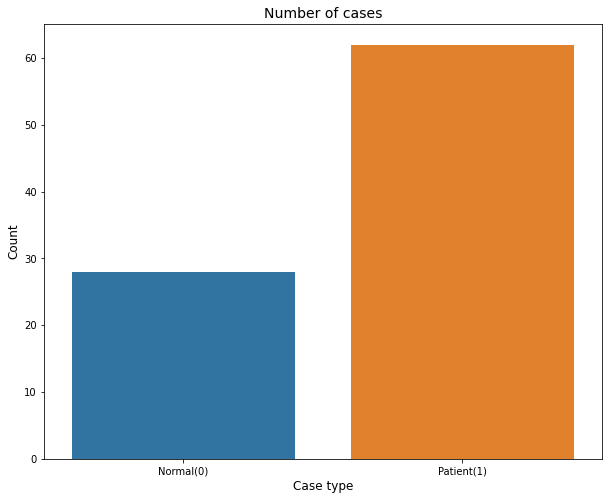

In [82]:
# Her durum için birer sayı alalım
cases_count = train_data['label'].value_counts()
print(cases_count)

# sonucu görselleştirelim
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Patient(1)'])
plt.show()

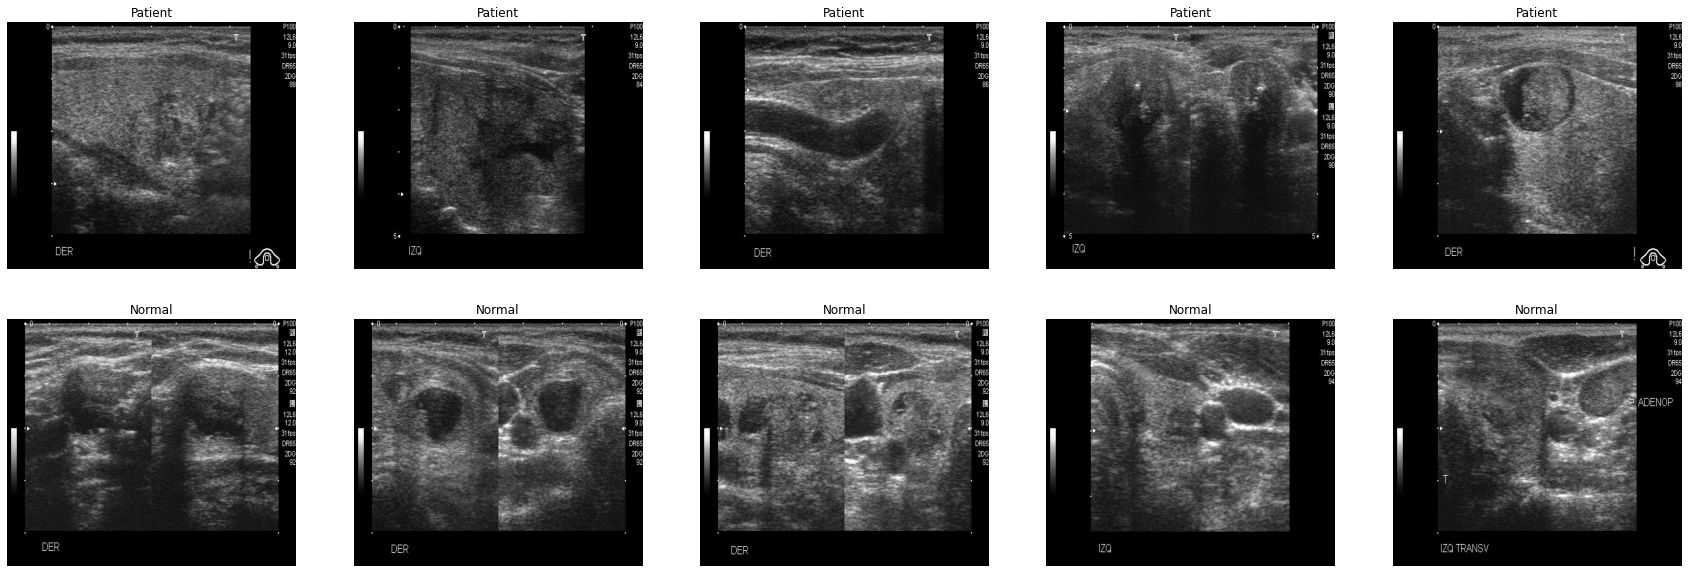

In [83]:
# her iki durum içinde birer örnek alıp inceleyelim
patient_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# verileri tek bir listede birleştireli ve her iki örnek için aldığımız listeyi silelim
samples = patient_samples + normal_samples
del patient_samples, normal_samples

# verilerin çıktıları
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Patient")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [84]:
normal_cases_dir = train_dir / 'normal' # Normal görüntüler
patient_cases_dir = train_dir / 'patient' # Hasta görüntüler

# Görselleştirmemiz vereken hasta olan ve normal görüntüleri alalım
normal_cases = normal_cases_dir.glob('*.jpg')
patient_cases = patient_cases_dir.glob('*.jpg')

# Doğrulama görüntüleri verilerini ve ilgili etiketleri içerecek olan liste
valid_data = []
valid_labels = []


# Bazı görüntüler gri tonlamalı, çoğu 3 kanal içeriyor.
# Yani görüntü gri tonlamalı ise 3 kanallı bir görüntüye dönüştüreceğiz.
# Piksel değerlerini normalleştireceğiz ve tüm resimleri 224x224 olarak yeniden boyutlandıracağız


# Normal vakalar 
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Hasta vakalar        
for img in patient_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Listeyi numpy dizilerine dönüştürün
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (90, 224, 224, 3)
Total number of labels: (90, 2)


In [12]:
# Büyütme Sırası
seq = iaa.OneOf([
    iaa.Fliplr(), # Yatay Çevirme
    iaa.Affine(rotate=20), # Dönüştürme
    iaa.Multiply((1.2, 1.5))]) # Rastgele Parlaklık


In [98]:
def data_gen(data, batch_size):
    # Verilerdeki toplam örnek sayısını alın
    n = len(data)
       
    steps = n//batch_size
    # Toplu verileri ve etiketleri içeren iki numpy dizisi tanımlayın
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Girdi verilerinin tüm dizinlerinin numpy dizisini alın
    indices = np.arange(n)
    
    # Sayacı Başlatın
    i = 0
    
    while True:
        np.random.shuffle(indices)
        # Bir sonrakine geç 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            
            encoded_label = to_categorical(label, num_classes=2)
            # Resimi oku ve yeniden boyutlandır
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # Gri tonlamalı olup olmadığını kontrol et
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # görüntü piksellerini normalleştir
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # yetersiz örneklenmiş sınıftan daha fazla örnek üretmek
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
              i=0

In [99]:
# Model

def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(32, (5,5), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(32, (5,5), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(64, (5,5), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(64, (5,5), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(128, (5,5), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(128, (5,5), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(128, (5,5), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(256,(5,5), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(256,(5,5), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(256,(5,5), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [100]:
model =  build_model()
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 32)      2432      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 32)      25632     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 64)      2912      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 64)      5760      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 64)       

In [111]:
# Open the VGG16 weight file
f = h5py.File('../dataSurgeryThyroid/tyroidXray/VGG-16/vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 32)      2432      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 32)      25632     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 64)      2912      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 64)      5760      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 64)       

In [112]:
opt = Adam(lr=0.0002, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [103]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 5 and 90


In [104]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                               class_weight={0:1.0, 1:0.4})


Epoch 1/34
5/5 [==============================] - 35s 7s/step - loss: 0.4900 - accuracy: 0.5000 - val_loss: 0.6952 - val_accuracy: 0.3111
Epoch 2/34
5/5 [==============================] - 47s 9s/step - loss: 0.4861 - accuracy: 0.5125 - val_loss: 0.7017 - val_accuracy: 0.3111
Epoch 3/34
5/5 [==============================] - 35s 7s/step - loss: 0.4985 - accuracy: 0.5750 - val_loss: 0.7186 - val_accuracy: 0.3111
Epoch 4/34
5/5 [==============================] - 35s 7s/step - loss: 0.4498 - accuracy: 0.4625 - val_loss: 0.7488 - val_accuracy: 0.3111
Epoch 5/34
5/5 [==============================] - 35s 7s/step - loss: 0.4256 - accuracy: 0.3875 - val_loss: 0.7695 - val_accuracy: 0.3111
Epoch 6/34
5/5 [==============================] - 36s 7s/step - loss: 0.4295 - accuracy: 0.4375 - val_loss: 0.7711 - val_accuracy: 0.3111


In [105]:
# Preparing test data
normal_cases_dir = test_dir / 'normal'
patient_cases_dir = test_dir / 'patient'

normal_cases = normal_cases_dir.glob('*.jpg')
patient_cases = patient_cases_dir.glob('*.jpg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

In [106]:
for img in patient_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

In [107]:
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (30, 224, 224, 3)
Total number of labels: (30, 2)


In [108]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=20)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)


2/2 [==============================] - 1s 671ms/step - loss: 0.7636 - accuracy: 0.3333
Loss on test set:  0.7635682225227356
Accuracy on test set:  0.3333333432674408


In [109]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(30,)
(30,)


In [119]:
# Get the confusion matrix
shuffle = False
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
figsize=(12,8)
alpha=(0.7)
plot_confusion_matrix(cm, orig_img, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Patient'], fontsize=10)
plt.yticks(range(2), ['Normal', 'Patient'], fontsize=10)
plt.show()

NameError: name 'orig_img' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))